# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



### Podział pracy:

**Dominika**: Zadania 1 i 3 <br><br>
**Aleksander**: Zadania 2 i 4

In [1]:
import pandas as pd
import requests
import zipfile
import io
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

from load_data import *
from compute_averages import *
from visualizations import *

# FIXME: usunąć zbędne importy (a niektóre będą zbędne skoro robimy wszystko importowanymi funkcjami)

### Zadanie 1

In [1]:
# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: '302', 2019: '322', 2024: '582'}
gios_pm25_file = {2014: '2014_PM2.5_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}

# funkcja do ściągania podanego archiwum
def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj
    
    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=0)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df

# Przykladowe użycie
df2014 = download_gios_archive(2014, gios_url_ids[2014], gios_pm25_file[2014])
df2019 = download_gios_archive(2019, gios_url_ids[2019], gios_pm25_file[2019])
df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

NameError: name 'requests' is not defined

In [9]:
#usuwanie pierwszego wiersza aby ujednolicić format
df2019.columns = df2019.iloc[0].astype(str).str.strip()
df2019 = df2019[1:]

df2024.columns = df2024.iloc[0].astype(str).str.strip()
df2024 = df2024[1:]

In [13]:
#pobranie metadanych

# AJ 03.01.26: strona nie daje poprawnej odpowiedzi i dlatego pd.read_excel() wyrzuca ValueError
metadata_url = 'https://powietrze.gios.gov.pl/pjp/archives/downloadFile/584'
metadata_response = requests.get(metadata_url)
metadata_response.raise_for_status()

dfmetadata = pd.read_excel(io.BytesIO(metadata_response.content), header=None)

#aktualizacja kodów stacji
new_codes = dict(zip(dfmetadata[4], dfmetadata[1]))

for df in ['df2014', 'df2019', 'df2024']:
    exec(f"{df} = {df}.rename(columns=new_codes)") 

ValueError: Excel file format cannot be determined, you must specify an engine manually.

In [ ]:
#pozostawienie w danych tylko tych stacji, które wystepują w we wszystkich latach, czyli 2014, 2019 i 2024
common_stations = (df2014.columns.intersection(df2019.columns).intersection(df2024.columns))

def only_common_stations(df, common):
    station_cols = [c for c in df.columns if c in common]
    return df[station_cols]

df2014 = only_common_stations(df2014, common_stations)
df2019 = only_common_stations(df2019, common_stations)
df2024 = only_common_stations(df2024, common_stations)

In [6]:
print("Liczba stacji w podanych latach:")
print(f"2014: {len(df2014.columns) - 1}")
print(f"2019: {len(df2019.columns) - 1}")
print(f"2024: {len(df2024.columns) - 1}")

Liczba stacji w podanych latach:
2014: 20
2019: 20
2024: 20


In [7]:
#dodanie miejscowości do kodów stacji za pomocą MultiIndex
code_city = dict(zip(dfmetadata[1], dfmetadata[11]))

multi_index = pd.MultiIndex.from_tuples([(code_city.get(code, None), code) for code in common_stations], names=["Miejscowość", "Kod stacji"])

df2014.columns = multi_index
df2019.columns = multi_index
df2024.columns = multi_index

In [8]:
#zmiana dnia pomiaru o północy na poprzedni
def change_midnight(df, start_row):

    df = df.copy()

    for i in range(start_row, len(df)):
        date = df.iloc[i, 0]
        day_hour = datetime.strptime(str(date), "%Y-%m-%d %H:%M:%S")
        if day_hour.hour == 0:
            day_hour -= timedelta(days=1)
        df.iloc[i, 0] = day_hour

    return df

df2014 = change_midnight(df2014, 5)
df2019 = change_midnight(df2019, 5)
df2024 = change_midnight(df2024, 5)

In [10]:
#dodanie kolumny year aby następnie połączyć wszystkie dane w jeden plik .csv
df2014.loc[:, 'year'] = 2014
df2019.loc[:, 'year'] = 2019
df2024.loc[:, 'year'] = 2024

all_data = pd.concat([df2014, df2019, df2024], ignore_index=True)
all_data.to_csv("all_data.csv", index=False)

### Zadanie 2

Poniższy kod wykonuje następujące zadania:
 - Obliczanie średniego miesięcznego stężenia PM2.5 dla każdej stacjii i roku.
 - Rysowanie wykresu liniowego miesięcznych wartości stężenia PM2.5 w **2015** i 2024 roku dla Warszawy i Katowic.

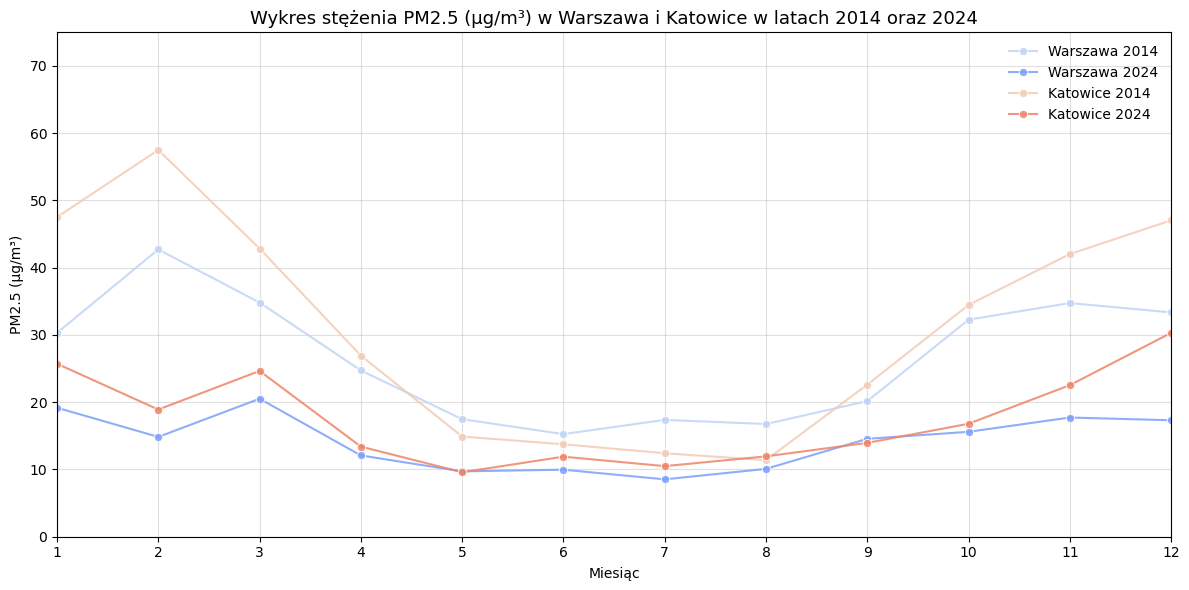

In [2]:
data = pd.read_csv("all_data.csv", header=0)
mean_df = monthly_average(data)

# FIXME: ZMIENIĆ NA 2015!
plot = plot_city_trends(mean_df, years=[2014, 2024])
plt.show(plot)

#### Interpretacja wyników **do poprawy (bo 2015 ma teraz być)**

Zarówno w Warszawie jak i w Katowicach średnie stężnie PM2.5 spadło między rokiem 2014 a 2024. W obydwu miastach poziom drobnych zanieczyszczeń jest większy w miesiącach zimowych niż w letnich. Podczas trwania sezonu grzewczego, poziom PM2.5 w danym miesiącu jest wyższy w Katowicach niż w Warszawie; poza sezonem grzewczym, zależność ta nie zachodzi.

W roku 2024, w obydwu miastach, różnice w stężeniu drobnego pyłu pomiedzy miesiącami letnimi i zimowymi są wyraźnie mniejsze niż w 2014. Być może wynika to z usprawnień w sposobie ogrzewania i termoizolacji budynków, które zostały wprowadzone w życie w ciągu tamtej dekady. 

In [3]:
# **FIXME:** Napisać nowe wnioski dla danych z innych lat!!!
# Tutaj muszę poczekać, na poprawione zadanie 1

### Zadanie 3

In [4]:
df = pd.read_csv("all_data.csv", header=None)
df.columns = df.iloc[0].astype(str).str.strip()
df = df[1:]

In [17]:
#obliczanie średniej miesięcznej PM2.5 dla każdej miejscowości oraz filtrowanie miast, w których brakuje średniej miesięcznej
def monthly_avg(df):
    df = df.copy()
    df = df.drop(columns=['year'], errors='ignore')

    locations = df.columns[1:]

    def unique_loc(names):
        how_many = {}
        locs = []
        for n in names:
            if n not in how_many:
                how_many[n] = 1
                locs.append(n)
            else:
                how_many[n] += 1
                locs.append(f"{n}{how_many[n]}")
        return locs
    
    unique_cols = unique_loc(locations)
    df.columns = [df.columns[0]] + list(unique_cols)

    cols_locations = dict(zip(unique_cols, locations))

    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]], format="%Y-%m-%d %H:%M:%S", errors='coerce')
    df = df.dropna(subset=[df.columns[0]]).reset_index(drop=True)

    for col in unique_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    long_format = df.melt(id_vars=df.columns[0], value_vars=unique_cols, var_name='station', value_name='pm25')
    long_format['location'] = long_format['station'].map(cols_locations)
    long_format['year'] = long_format[df.columns[0]].dt.year
    long_format['month'] = long_format[df.columns[0]].dt.month

    monthly = long_format.groupby(['location', 'year', 'month'], as_index=False)['pm25'].mean()

    all_locations = []
    for loc in monthly['location'].unique():
        df_loc = monthly[monthly['location'] == loc]
        if not df_loc['pm25'].isna().any():
            all_locations.append(loc)

    monthly_filtered = monthly[monthly['location'].isin(all_locations)].copy()

    return monthly_filtered

In [18]:
monthly = monthly_avg(df)
locations = monthly['location'].unique()
zmin = monthly['pm25'].min()
zmax = monthly['pm25'].max()
years = [2014, 2019, 2024]

n = len(locations)
rows = int(np.ceil(n / 2))
cols = 2

fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f"{loc}" for loc in locations])
colorscale = "Viridis"

for i, loc in enumerate(locations):
    row = i // 2 + 1
    col = i % 2 + 1

    dfloc = monthly[(monthly['location'] == loc) & (monthly['year'].astype(int).isin(years))]

    heatmap_data = dfloc.pivot(index='year', columns='month', values='pm25')
    y = heatmap_data.index.astype(str)[::-1]

    showscale = True if i == 0 else False

    hm = go.Heatmap(z=heatmap_data.values[::-1, :], x=heatmap_data.columns, y=y,
                    colorscale=colorscale,
                    zmin=zmin, zmax=zmax,
                    colorbar=dict(title=dict(text="PM2.5 µg/m³"),
                                tickmode="array",
                                tickvals=np.linspace(zmin, zmax, 5),
                                ticktext=[f"{v:.0f}" for v in np.linspace(zmin, zmax, 5)],
                                len=0.2,
                                y=0.7,
                                x=1.05),
                    hovertemplate="Rok: %{y}<br>Miesiąc: %{x}<br>PM2.5: %{z} µg/m³",
                    showscale=showscale)

    fig.add_trace(hm, row=row, col=col)

fig.update_xaxes(tickmode="array", tickvals=list(range(1, 13)), ticktext=list(range(1, 13)))

for i in range(1, rows*cols + 1):
    fig.update_yaxes(categoryorder='array',
                    categoryarray=[str(y) for y in years],
                    autorange="reversed",
                    row=(i-1) // 2 + 1,
                    col=(i-1) % 2 + 1)

fig.update_layout(height=350 * rows, width=1000, title=dict(text='Średnie PM2.5 w latach 2014, 2019 i 2024', x=0.5, y=0.99), font=dict(size=12))

fig.show()

#### Interpretacja powyższych obserwowanych wyników
W każdym roku można zaobserwować wyższe stężenia PM2.5 w okresie zimowym oraz niższe latem. Jak można byłoby się spodziewać, w większych miastach wartości PM2.5 są wyższe niezależnie od pory roku. Jednocześnie widoczna jest wyraźna tendencja spadkowa między analizowanymi latami, co wskazuje na poprawę jakości powietrza w danych miejscowościach.

### Brudnopis

### Zadanie 4

Poniższy kod wykonuje następujące zadania:
 - Zliczanie dni, w których została przekroczona norma PM2.5 w danej stacji pomiarowej, w danym roku.

 - Identyfikacja trzech stacji z największą oraz trzech stacji z najmniejszą liczbą takich dni w 2024 roku.

 - Rysowanie wykresu typu *grouped barplot* poziomów stężenia PM2.5 dla 6. zidentyfikowanych stacji w latach 2015, 2018, 2021 i 2024.

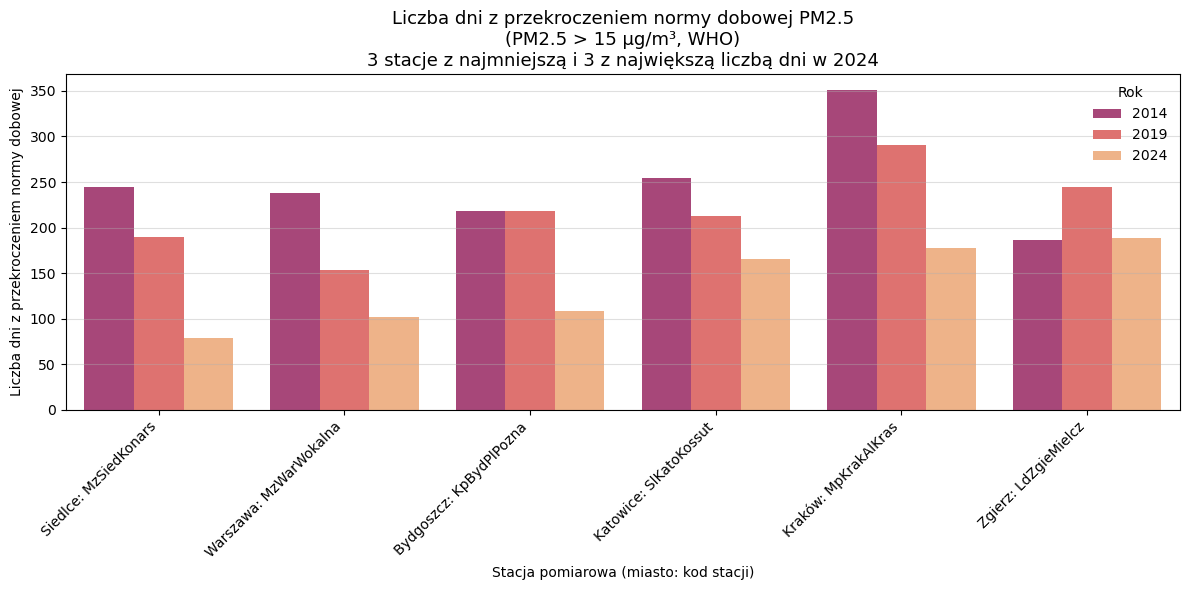

In [4]:
who_threshold = 15
metadata_idx = 3
top_n = 3


all_data = pd.read_csv("./all_data.csv", header=0)

exceedance_counts = count_days_over_treshold(data=all_data,treshold=who_threshold)
barplot = plot_pm25_exceedance_bars(exceedance_counts, top_n=top_n, base_year=2024, threshold=who_threshold) 

plt.show(barplot)

In [ ]:
# **FIXME:** Napisać nowe wnioski dla danych z innych lat!!!
# 2015, 2018, 2021 i 2024
# Tutaj muszę poczekać, na poprawione zadanie 1

#### Interpretacja wyników **do poprawy (ma być 2015, 2018, 2021 i 2024)**

Powyższy wykres pokazuje liczbę dni, w których średnie dobowe stężenie PM2.5 przekroczyło wartość 15 µg/m³ dla sześciu wybranych stacji - trzech z najmniejszą (wykresy 1-3) i trzech z największą (wykresy 4-6) liczbą przekroczeń w 2024 r. Stacje z największą liczbą przekroczeń wykazują wyraźnie gorszą jakość powietrza w niemal wszystkich porównywanych latach, co sugeruje trwałe źródła emisji lub niekorzystne warunki meteorologiczne.

Zgodnie z tym co zauwożono w poprzednich zadaniach, stężenie PM2.5 zmierzone przez daną stację ma trend spadkowy w czasie.

### Ogólna interpretacja obserwowanych wyników **do poprawy (ma być 2015, 2018, 2021 i 2024)**

Średnie miesięczne wartości PM2.5 w latach 2014, 2019 i 2024 wskazuje na tendencję spadkową zanieczyszczenia powietrza w badanym okresie. Najwyższe wartości można zaobserwować w większych miastach, co może wiązać się z większym natężeniem ruchu drogowego i działalności przemysłowej. Dodatkowo dane wskazują na zależność stężenia PM2.5 od pory roku - wartości są najniższe w  miesiącach letnich, a wzrastają w sezonie zimowym, co prawdopodobnie wynika z ogrzewania budynków i wcześniej wspomnianym większym natężeniem ruchu drogowego. Średnie miesięczne wartości PM2.5 są zatem ściśle związane z działalnością człowieka i porą roku.